# HW4: Large Language Models

In this assignment, you will be implementing language models for next token prediction and generation of Shakespeare! This assignment will be in two parts. **For this final assignment, you have the option to work in pairs.**

**Part 1:**

In this part, you will review some key ingredients of sequence modeling. In the process, you will build a baseline transformer model for next token prediction trained on Shakespeare's works. We have provided the scaffoldin for the code in this part of the assignment, and your task will be to fill in the key implementation steps.

**Part 2:**

This part is an open-ended mini-project where you have the freedom to try sequence modeling approaches of your choice on this problem. You should feel free to try other architectures (HMMs, RNNs, transformers, state space layers, diffusion models etc.) or to invent new architectures. You may also experiment with new algorithms for fitting or training these models. The goal will be to find some area of possible improvement (we interpret "improvement" quite loosely, but it is up to you to state precisely why your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not); to formulate and state a precise hypothesis; and to falsify or support the hypothesis with rigorous empirical analyses.

**Deliverables:**

- Code for Parts 1 of the assignment
- A written report of at most 4 pages for Part 2 (references not included in the page limit), with a link to code for Part 2.

_Note: the code for Part 2 will not be graded, but we ask you to include a link to it for completeness._

**Important: Choosing runtimes**

Google Colab has limits on the free usage of GPU runtimes. For this assignment, **we strongly recommend doing the majority of your prototyping, testing, and small-scale experiments on CPU backend**. Then, once you are ready to train your models, you should switch to a T4 GPU.

You can change runtime type by clicking **Runtime -> Change Runtime Type** in the tabs above. You can monitor your resource usages in the top right corner of the screen (it should say what backend you are using, how many compute units per hour you are using, etc.)

**Make sure to turn off GPU runtime if you are not actively using it!**






## Setup

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [2]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Part 0: Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading and preprocessing the dataset


The first step is to download the dataset. We will be using a dataset from Andrej Karpathy consisting of a subset of works from Shakespeare.

The dominant mode for preprocessing textual data is to tokenize it; that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionaries mapping from counting numbers (representing tokens) to tokens and vice versa. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research.

To keep things simple, we'll tokenize the text on a per-character level.

In [3]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [4]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 1,003,854 tokens
val has 111,540 tokens


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [6]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

## Part 1: Language Modeling

In this first part of the assignment, we will implement a baseline for code modeling.

In the process of building this baseline, we will review 4 key ideas of sequence modeling that have become the backbone of modern language models such as ChatGPT:

1. Framing language modeling as next token prediction, and next token prediction as multiclass logistic regression
2. Embedding discrete tokens in continuous latent spaces (word embeddings)
3. Use the attention mechanism to move beyond Markovian models for sequences (we of course pay for this greater expressivity with increased compute, which is made possible in part by using matrix multiplications on hardware accelerators like GPUs. Reducing the compute burden while maintaining the expressivity needed for good sequence modeling is an active area of research).
4. Combining attention with deep learning in the Transformer architecture.

### 1.1: Next token prediction as multiclass logistic regression

Our first language model will simply be a lookup table. That is, given that we have token with value $v$, we will simply "look up" the logits that correspond to our prediction for the next token. This model is often known as a "bigram model" because it can be derived from the relative proportions of different bigrams (ordered pairs of tokens) occurring in a large text corpus.

Let us be a bit more precise in our definition of the bigram model. Let's say that the total size of our vocabulary (the number of tokens we are using) is $V$. Let $A$ be a matrix in $\mathbb{R}^{V \times V}$, where each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$.
Thus, we are modeling the distribution of the token following a token that has value $v$ as
\begin{align*}
y_{t+1} \mid y_t &= v \sim \mathrm{Cat}(\mathbf{\pi}) \\
\pi &=\mathrm{softmax}(A_v)
\end{align*}

#### Question 1.1.1

$\mathbf{\pi} \in \Delta_{V-1}$ is the vector of probabilities used to parameterize the categorical distribution for the next token prediction. Explain why we parameterize
\begin{equation*}
  \mathbf{\pi} = \mathrm{softmax}(A_v),
\end{equation*}
and could not just use
\begin{equation*}
  \mathbf{\pi} = A_v.
\end{equation*}

---

_your answer here_

**Answer 1.1.1**

The softmax function is used to normalize $A_v$ so that the it sums to 1. This is required to have a probabilistic interpretable. Normalizing also makes the computatio more numerically stable, as seen from the previous homework.

---

#### Question 1.1.2

Discuss the relationship between the bigram model and contigency tables (discussed in Lecture 1).

---

_your answer here_

**Answer 1.1.2**

The contigency tables discussed in Lecture 1 record the joint distribution of two categorical random variables, and in this setting, it can be thought of as the joint distribution of the vocabulary at $t$ and at $t+1$ (aka adjacent tokens). We can interpret $A_v$ in the Bigram model as the contingency table.

---

#### Question 1.1.3

Say I have a string of three tokens with ids $(7, 3, 6)$. If I use the bigram model as a generative model for language, given this information, what is distribution of the fourth token? Write your answer in terms of the matrix $A$ we defined in 1.1

---

_your answer here_

**Answer 1.1.3**

The distribution of the fourth token is given as:
$$
y_4 \mid y_3 = 6 \sim \mathrm{Cat}(\pi), \pi = \mathrm{softmax}(A_{6})
$$

---

#### Question 1.1.4

Remember back in Part 0 when we gave you the helper function `get_batch`? Run `get_batch` and look at the inputs `x` and the targets `y`. Explain any relation between them in the context of formulating language modeling in the context of next token prediction.

In [7]:
xb, yb = get_batch('train', 10, device, batch_size = 1)
print(f"the features have token ids {xb}")
print('\n')
print(f"the targets have token ids {yb}")

the features have token ids tensor([[47, 53, 59, 57,  1, 50, 53, 60, 43,  6]])


the targets have token ids tensor([[53, 59, 57,  1, 50, 53, 60, 43,  6,  0]])


---

_your answer here_

**Answer 1.1.4**

Look at the following lines:

`x = torch.stack([data[i:i+context_window_size] for i in ix])`

`y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])`

In the context of the next token prediction, the inputs `x` corresponds to the column indices of $A_v$, and the target `y` corresponds to the row indices of $A_v$. Recall that each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$. Thus, the results from running `get_batch` gives an example - token 53 following token 47, token 59 following token 53, and so on.

---

#### Question 1.1.5

Discuss the strengths and weaknesses of the bigram model as a generative model for language.

---

_your answer here_

**Answer 1.1.5**

**Strengths**:

- Relative Interpretability. The bigram model is based on a simple look up table, which can be thought of as a frequentist view of next token prediction trained on massive amount of data.

- Fast compute and low memory requirement. As the bigram model only concerns with one lookup table, the model inference can be done in just one compute iteration. This is incredibly fast. We also need to store only one lookup table of size $V \time V$, which takes up only a little bit of memory when compared with other generative models.


**Weaknesses**:

- Limited contextual understanding. As the bigram model only looks at adjacent tokens, the model cannot have long term contextual understanding by this design. This can be problematic when generating realistic texts.

- Noise in prediction. As the vocabulary is rich ($V$ is oftentimes very large), and the occurences are always binary (one token following another), the lookup table can be really sparse, and the prediction can get be very noisy, i.e. we will end up having a very high variance estimate.

- Some convergence issue in multinomial logit. The convergence of multinomial logit may become challenging in such a setting, where the dimensionality is high and the matrix is sparse, and possible pathologies include unstable gradients and slow convergence.

---

#### Question 1.1.6

Say I have a string $s$ of length $T$. Derive the formula for the negative log likelihood of $s$ under the bigram model in terms of the matrix of logits $A$. What would your answer be if the matrix of logits $A$ were all zeros? What would be the value of the negative log likelihood of $s$ under a model that always perfectly predicted the next token?

---

_your answer here_

**Answer 1.1.6**

Derivation of the negative log likelihood formula:

Following the notation, suppose we have $s = (y_1, y_2, ..., y_T)$, the likelihood for $s$ is given as $P(s) = \prod_{t = 1}^{T-1} P(y_{t+1} \mid y_t)$, where $P(y_{t+1} \mid y_t) = \frac{\exp{(A_{y_{t}, y_{t+1}})}}{\sum_{i\in V} \exp{(A_{y_{t}, i})}}$ by expanding out the softmax function. Thus, the negative log likehood is:
$$
-\log P(s) = - \sum_{t=1}^{T-1} \left[A_{y_{t}, y_{t+1}} - \log \left(\sum_{i\in V} \exp{(A_{y_{t}, i})}\right) \right]
$$

Special cases:

(1) *Matrix of logits $A$ were all zeros*:

Recognize that with $A_{y,i} = 0 \ \forall i \in V$, $- \log P(s) = (T-1) \log(V)$.


(2) *Under a model that always perfectly predicted the next token*:

For a perfect model, $A_{y_{t}, y_{t+1}} = 1$ and $A_{y,i} = 0 \ \forall i \in V ∖ \{y_{t+1}\}$. Thus, $- \log P(s) = 0$.


---

#### Question 1.1.7: Implement the BigramLanguageModel

Implement the bigram language model below.

Your TODOs:
  * if the `forward` method is provided a target, the loss should be the negative log likelihood of the target (given the context)
  * `generate` should take in (batched) contexts and a number of new tokens to generate, and then generate text autoregressively from your model. Note that in autoregressive text generation, you iteratively append the tokens you generate to your context.


In [8]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Args:
          vocab_size: size of the vocabulary (the number of tokens)
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.logits_table = nn.Embedding(vocab_size, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: Int(B, T), token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: Int(B, T), token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """

        # idx and targets are both (B,T) tensor of integers
        logits = self.logits_table(token_ids) # (B,T,V)

        if targets is None:
            loss = None
        else:
            # TODO: what should the loss in this setting be?
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        for _ in range(max_new_tokens):
          logits, loss = self(token_ids)
          logits = logits[:, -1, :]
          probs = F.softmax(logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)
          token_ids = torch.cat((token_ids, next_token), dim=1)
        return token_ids


#### Question 1.1.8: Evaluating the initialization.

Evaluate the loss of your untrained bigram model on a batch of data. Make sure the loss (negative log likelihood) is per-token (i.e. you may need to average over both sequence length and batch). Does this loss make sense in the context of your answer to Question 1.1.6? Discuss.

In [9]:
x,y = get_batch("train", CONTEXT_WINDOW_SIZE, device)
bigram_model = BigramLanguageModel(vocab_size)
bm = bigram_model.to(device)

# TODO: your code below
logits, loss = bm(x, y)
# The loss is per-token as we calculated the loss using F.cross_entropy
print("Loss per token: ", loss.item())

Loss per token:  4.660638809204102


In [20]:
torch.log(torch.tensor(vocab_size))

tensor(4.1744)

---

_your answer here_

**Answer 1.1.8**

Yes, this loss makes sense in the context of my answer to Question 1.1.6. In 1.1.6, we know that $- \log P(s) = (T-1) \log(V)$ if the matrix of logits $A$ were all zeros. Thus, the per-token loss for such a model is $\log(V)$. We also know that this loss equals 0 for a perfect model.

 From the code above, we can see that the loss per token for this batch of data is very close to $\log(V)$. This makes sense, since this untrained model should have almost no predictive power, making the loss very close to $\log(V)$.

---

#### Question 1.1.9: Training your bigram model

Train your bigram model for `SMALL_ITERS` iterations. Plot and interpret the loss curve.

Our train loss gets down to around 2.5 after 1000 iterations.

In [21]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|          | 10/1000 [00:01<01:21, 12.12it/s]

step 0: train loss 4.6454, val loss 4.6532


 20%|█▉        | 196/1000 [00:02<00:07, 111.16it/s]

iteration 200


 22%|██▏       | 220/1000 [00:03<00:18, 43.15it/s]

step 200: train loss 2.8995, val loss 2.9157


 40%|███▉      | 399/1000 [00:05<00:05, 111.89it/s]

iteration 400


 42%|████▏     | 423/1000 [00:06<00:13, 43.13it/s]

step 400: train loss 2.5581, val loss 2.5770


 59%|█████▉    | 594/1000 [00:07<00:03, 102.39it/s]

iteration 600


 62%|██████▏   | 615/1000 [00:09<00:10, 35.23it/s]

step 600: train loss 2.4962, val loss 2.5211


 79%|███████▊  | 787/1000 [00:10<00:01, 120.69it/s]

iteration 800


 81%|████████  | 812/1000 [00:11<00:04, 46.60it/s]

step 800: train loss 2.4797, val loss 2.5081


 99%|█████████▉| 988/1000 [00:13<00:00, 123.80it/s]

iteration 999


100%|██████████| 1000/1000 [00:14<00:00, 70.61it/s]

step 999: train loss 2.4728, val loss 2.5016


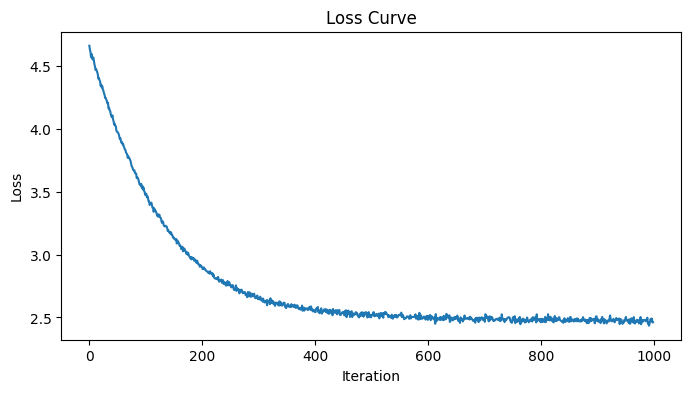

In [23]:
plt.figure(figsize=(8,4))
plt.plot(torch.tensor(loss_list))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

---

_your answer here_

---

Note that these models can take up a lot of memory on the GPU. As you go through this assignment, you may want to free the models after you train them using code along the lines of
```
model.to('cpu')
torch.cuda.empty_cache()
```

### 1.2: Token Embeddings: going from discrete tokens to continuous latent spaces

In the look up table formulation of the bigram model, we are modelling the logits of the next token didstirbution independently for each token, even if two tokens are extremely similar to each other.
One way arond this problem is to learn an embedding of the discrete tokens into $\mathbb{R}^{D}$, and then to run multi-class logistic regression on top of this learned embedding.

More precisely, if we have a vocabulary of tokens of size $V$ that we choose to embed in a Euclidean embedding space of dimension $D$, we can parameterize the distribution of the next token if the current token is $v$ according to
\begin{align*}
  \mathrm{Cat}\Big( \mathrm{softmax} (\beta X_v) \Big),
\end{align*}
where $X_v \in \mathbb{R}^{D}$ is the learned embedding of token $v$ into $\mathbb{R}^{D}$ and $\beta \in \mathbb{R}^{V \times D}$. Notice that if $X$ were a fixed design matrix this formulation would be equivalent to multi-class logistic regression. However, both $X$ and $\beta$ are learnable parameters.

#### Question 1.2.1: Implement BigramWithWordEmbeddingsLM

Implement a bigram languge model that uses a linear readout from a low dimensional Euclidean embedding of each token to parameterize the logits of the next token distribution, instead of parameterizing the logits of the next token distribution directly. It should have almost the same implementation as `BigramLanguageModel` from Question 1.1.6, except `init` should also take in an `embed_size`, and the `forward` method will need to be modified.

In [ ]:
class BigramWithWordEmbeddingsLM(nn.Module):

    def __init__(self, vocab_size, embed_size=32):
      """
      Args:
        vocab_size: int, size of the vocabulary
        embed_size: int, dimension of the word embedding (D)
      """
      super().__init__()
      #TODO, your code here
      pass

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO, your code here

        logits = None
        loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below


#### Question 1.2.2: Training your bigram model with word embeddings

Train your bigram model with word embeddings for `SMALL_ITERS` iterations. Plot and interpret the loss curve. How does the final loss compare to that of the bigram model without embeddings? Why do you think this is?

Our train loss gets down to around 2.5 after 1000 iterations.

In [ ]:
bigram_model_embed = BigramWithWordEmbeddingsLM(vocab_size)
bm_e = bigram_model_embed.to(device)

learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model_embed.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm_e, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm_e(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

---

_your answer here_

---

### 1.3: Attention: Relaxing Markovian assumptions to transmit information across the sequence length

A major problem with the bigram models of Sections 1.1 and 1.2 was that they were Markovian: the distribution of the next token was determined entirely by the current token! The attention mechanism provides a way to extract information between the previous tokens in the context to provide a better parameterization for the distribution of the next token.

#### Question 1.3.1: Averaging over word embeddings

One simple way to pool information would simply be to average the embeddings!

Your TODO: Add comments to the the code snippet below. Write a description here explaining why the code is mathematically equivalent to averaging the embeddings of the previous tokens and the current token.

---

_your answer here_

---

In [ ]:
# average word embedding via matrix multiply and softmax
small_batch_size = 4              # B
small_context_window_size = 8     # T
small_embed_size = 2              # D

# make "synthetic" word embeddings (for illustration purposes only)
X = torch.randn(small_batch_size, small_context_window_size, small_embed_size)

# TODO: comment the code below
print(X.shape)
tril = torch.tril(torch.ones(small_context_window_size, small_context_window_size))
attn_weights = torch.zeros((small_context_window_size, small_context_window_size))
attn_weights = attn_weights.masked_fill(tril == 0, float('-inf'))
attn_weights = F.softmax(attn_weights, dim=-1)
avg_embeddings = attn_weights @ X
print(X[0])
print("")
print(avg_embeddings[0])

#### 1.3.2: Single-headed scaled $(Q,K,V)$-attention

A more sophisticated approach than simply averaging over previous word embeddings is single-headed (Query, Key, Value) scaled attention.
That is, we now summarize the information contained in a length $T$ sequence of tokens that have been embeded into $X \in \mathbb{R}^{T \times D}$ according to
\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}
where $U_q, U_k \in \mathbb{R}^{K \times D}$, $V \in \mathbb{R}^{D \times D}$, and $K$ is the "head size".



##### Question 1.3.2.1

In the limiting case where $U_q$ and $U_k$ are all zeros, and $V = I_{D}$, what does $(U_q, U_k, V)$ attention simplify to?

---

_your answer here_

---

##### Question 1.3.2.2: Implement single-headed scaled $(U_q,U_k,V)$-attention.

Complete the below code so the `forward` method returns single-headed scaled $(U_q,U_k,V)$-attention.

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        pass

##### Question 1.3.2.3: Implement a single-headed attention language model

Complete the code below. Note that because the transformer has no idea where tokens are occuring in space, we have also added in position embeddings.

In [ ]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(...)
      self.lm_head = nn.Linear(...)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        logits = ...
        loss = ...

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        pass

Train your new `SingleHeadedAttentionLM` for `SMALL_ITERS` training iterations and plot the loss curve.
The `head_size` shouldn't matter too much, we just use the `embedding_size`.
Do you seen an improvement compared to your `BigramLanguageModel`? Discuss.

Note: you may want to modify the learning rate. Training for `SMALL_ITERS` with a learning rate of `6e-4`, we can get to a train loss of around 2.3.

In [ ]:
embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE, embed_size, embed_size)
sham = sha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

---

_your answer here_

---

#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_window_size, num_heads, head_size, embed_size=384):
        """
        Args:
            context_window_size: int, number of tokens considered in the past for attention (T)
            num_heads: int, number of heads (H)
            head_size: int, size of the head embedding dimension
            embed_size: int, size of the token embedding dimension
        """
        super().__init__()
        # TODO, your code below
        self.heads = nn.ModuleList(...)

    def forward(self, x):
        # TODO, your code below
        pass

##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 2 after 1000 iterations, which takes around 1.5 minutes on a T4 GPU.

In [ ]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        logits = ...
        loss = ...

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        pass

In [ ]:
# Initialize model
model = MultiHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE)
m = model.to(device)

# create a PyTorch optimizer
learning_rate = 6e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(m, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

---

_your answer here_

---

### 1.4: The Transformer Architecture: combining attention with deep learning

In [ ]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

#### Question 1.4.1: Implement a transformer block

Complete the code below to implement a transformer block

To make the your implemenation easier to train, we have added two deep learning best practices:

1. Residual connections.

    In the `forward` method of the `TransformerBlock`, we have implemented a residual connection of the form
    
    \begin{align*}
    x \mapsto x + f(x)
    \end{align*}
    
    where $f$ is a nonlinear function. The idea is that every layer is some adjustment of the identity function, which guards against vanishing gradients in a deep network during back propogation, especially at initialization.

2. Prenorm via `LayerNorm`

    Also in the `forward` method of the `TransformerBlock`, the nonlinearity first applied a `LayerNorm` to its arguments. The `LayerNorm` basically standardizes the activations in that layer so that they have mean 0 and variance 1. Doing so is very helpful for numerical stability, espeically of the gradients.

In [ ]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(...)
        self.atten_heads = ...

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

#### Question 1.4.2: Implement your baseline transformer model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

In [ ]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = ...
        loss = ...

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        pass

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 1.4 in around 15 minutes of training on a T4 GPU.

In [ ]:
trans = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

#### Question 1.4.3: Generating text!

Now with our trained model, we can generate some text that is somewhat like the style of Shakespeare! Below we will do both unconditional and conditional generation.

In [ ]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(uncond_gen))

In [ ]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

In [ ]:
cond_gen = (tlm.generate(context1_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen))

TODO: Choose your own context from Shakespeare, and perform conditional generation from that text. Does this look reasonable to you? Why or why not?

In [ ]:
# TODO: your code here

---

_your answer here_

---

#### Question 1.4.4

The negative log-likelihood (averaged per token) we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perplexity is. Why might it be a more intuitive or natual measure to report than negative log-likelihood? Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (Be sure to distinguish betwen `train` and `validation` perplexity. Which of `train` and `val` perplexity is more helpful for understanding your generated samples? Why?). (*Hint: your answer to Question 1.1.6 may be helpful*).

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

## Submission Instructions

You will generate two PDFs: one from Part 1, which involves completing this Colab to create a transformer baseline; and one from the mini-project in Part 2, which will be your write-up of no longer than 4 pages. Be sure to include a link to your code for Part 2 somewhere in your writeup.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope and tag your group members. If you complete the assignment individually, submit as usual.